# STAT7008 Project: Recommendation System

Import necessary installation packages

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score

In [2]:
# !sh scripts/process.sh

### (1)

Typical recommendation algorithms: Content-based filtering, Item-based collaborative filtering, and User-based collaborative filtering

Data Loading:

In [3]:
datapath = "data/ml-1m/"

# Load Movies
movies = pd.read_csv(datapath + 'movies.dat', delimiter='::', engine='python', header=None, names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

# Load Ratings
ratings = pd.read_csv(datapath + 'ratings.dat', delimiter='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin-1')

# Load Users
users = pd.read_csv(datapath + 'users.dat', delimiter='::', engine='python', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin-1')

Content-Based Filtering: 

In [4]:
# Create a TF-IDF matrix of unigrams, bigrams, and trigrams for each movie's genre
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['Genres'])

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get recommendations based on the cosine similarity score of movie genres
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies[movies['Title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # 10 most similar movies
    movie_indices = [i[0] for i in sim_scores]
    return movies['Title'].iloc[movie_indices]

# Example usage
recommendations = get_recommendations('Toy Story (1995)')
recommendations

1050            Aladdin and the King of Thieves (1996)
2072                          American Tail, An (1986)
2073        American Tail: Fievel Goes West, An (1991)
2285                         Rugrats Movie, The (1998)
2286                              Bug's Life, A (1998)
3045                                Toy Story 2 (1999)
3542                             Saludos Amigos (1943)
3682                                Chicken Run (2000)
3685    Adventures of Rocky and Bullwinkle, The (2000)
12                                        Balto (1995)
Name: Title, dtype: object

Item-Based Collaborative Filtering

In [5]:
# Create a pivot table with movies as rows and users as columns
movie_ratings = ratings.pivot_table(index='MovieID', columns='UserID', values='Rating').fillna(0)
item_similarity = cosine_similarity(movie_ratings)

# Function to recommend movies based on item similarity
def get_item_based_recommendation(movie_id):
    # Get movie index for similarity matrix
    idx = movies[movies['MovieID'] == movie_id].index[0]
    similar_scores = item_similarity[idx]
    similar_movies = list(movie_ratings.index[np.where(similar_scores > 0.5)])
    similar_movies.remove(movie_id)  # Remove the movie itself from the recommendation
    return movies[movies['MovieID'].isin(similar_movies)]['Title']

# Example usage
recommendations = get_item_based_recommendation(1)  # For movie with MovieID 1
recommendations[:10]

33                                   Babe (1995)
38                               Clueless (1995)
257    Star Wars: Episode IV - A New Hope (1977)
293                          Pulp Fiction (1994)
315             Shawshank Redemption, The (1994)
352                          Forrest Gump (1994)
360                        Lion King, The (1994)
453                         Fugitive, The (1993)
476                         Jurassic Park (1993)
584                               Aladdin (1992)
Name: Title, dtype: object

User-Based Collaborative Filtering:

In [6]:
# Create a pivot table with users as rows and movies as columns
user_ratings = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating').fillna(0)
user_similarity = cosine_similarity(user_ratings)

# Function to recommend movies based on user similarity
def get_user_based_recommendation(user_id):
    # Get user index for similarity matrix
    idx = users[users['UserID'] == user_id].index[0]
    similar_users = user_similarity[idx]
    similar_users_index = np.where(similar_users > 0.5)[0]
    recommended_movies = set()
    for i in similar_users_index:
        movies_rated_by_similar_user = user_ratings.columns[np.where(user_ratings.iloc[i] > 3)].tolist()
        recommended_movies.update(movies_rated_by_similar_user)
    return movies[movies['MovieID'].isin(recommended_movies)]['Title']

# Example usage
recommendations = get_user_based_recommendation(1)  # For user with UserID 1
list(recommendations)[:10]

['Toy Story (1995)',
 'Pocahontas (1995)',
 'Apollo 13 (1995)',
 'Star Wars: Episode IV - A New Hope (1977)',
 "Schindler's List (1993)",
 'Secret Garden, The (1993)',
 'Aladdin (1992)',
 'Snow White and the Seven Dwarfs (1937)',
 'Beauty and the Beast (1991)',
 'Fargo (1996)']

### (2)

Deep learning-based algorithms

Neural Collaborative:

In [7]:
from src.model import NCF

In [8]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings):
        self.users = torch.tensor(ratings['UserID'].values, dtype=torch.long)
        self.movies = torch.tensor(ratings['MovieID'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings['Rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

In [9]:
ratings = pd.read_csv(datapath + 'ratings.dat', delimiter='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin-1')

ratings['UserID'] = ratings['UserID'] - 1
ratings['MovieID'] = ratings['MovieID'] - 1

In [10]:
dataset = MovieLensDataset(ratings)
ncf_dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

num_users = ratings['UserID'].max() + 1
num_movies = ratings['MovieID'].max() + 1
ncf_model = NCF(num_users, num_movies, 64, [128, 64, 32])

optimizer = torch.optim.Adam(ncf_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(5):
    ncf_model.train()
    for users, movies, ratings in ncf_dataloader:
        optimizer.zero_grad()
        predictions = ncf_model(users, movies)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 1.0219801664352417
Epoch 1, Loss: 0.956095278263092
Epoch 2, Loss: 0.8242071270942688
Epoch 3, Loss: 0.8698427677154541
Epoch 4, Loss: 0.661267101764679


GNN-based recommendation algorithms:

In [11]:
from src.model import GCN

In [12]:
ratings = pd.read_csv(datapath + 'ratings.dat', delimiter='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin-1')

ratings['UserID'] = ratings['UserID'] - 1
ratings['MovieID'] = ratings['MovieID'] - 1

edge_index = torch.tensor([ratings['UserID'], ratings['MovieID']], dtype=torch.long)
edge_weight = torch.tensor(ratings['Rating'], dtype=torch.float)

num_users = ratings['UserID'].max() + 1
num_movies = ratings['MovieID'].max() + 1
num_features = num_users + num_movies
hidden_channels = 64

x = torch.eye(num_features)
gcn_model = GCN(num_features, hidden_channels)
optimizer = optim.Adam(gcn_model.parameters(), lr=0.01)

user_nodes = edge_index[0]
movie_nodes = edge_index[1] + num_users
losses = []

for epoch in range(100):
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(x, edge_index, edge_weight)

    predicted_ratings = (out[user_nodes] * out[movie_nodes]).sum(dim=1)
    loss = F.mse_loss(predicted_ratings, edge_weight)
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 13.973033905029297
Epoch 10, Loss: 7.738231658935547
Epoch 20, Loss: 5.878369331359863
Epoch 30, Loss: 3.0023982524871826
Epoch 40, Loss: 1.2275882959365845
Epoch 50, Loss: 1.1569361686706543
Epoch 60, Loss: 1.0895942449569702
Epoch 70, Loss: 1.0381094217300415
Epoch 80, Loss: 1.0215544700622559
Epoch 90, Loss: 1.0132155418395996


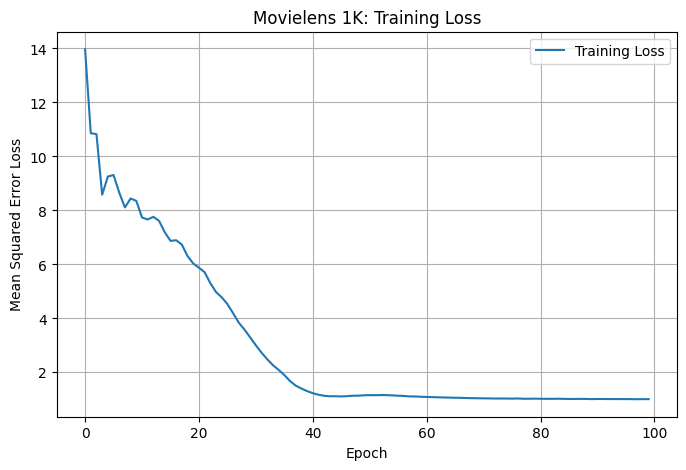

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss')
plt.title('Movielens 1K: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
ratings = pd.read_csv("data/last_fm/user_artists.dat", delimiter='\t', engine='python', encoding='latin-1')

ratings['userID'] = ratings['userID'] - 1
ratings['artistID'] = ratings['artistID'] - 1

ratings['label'] = ratings['weight'].apply(lambda x: 0 if x < 0.0 else 1)

edge_index = torch.tensor([ratings['userID'], ratings['artistID']], dtype=torch.long)
edge_weight = torch.tensor(ratings['label'], dtype=torch.float)

num_users = ratings['userID'].max() + 1
num_movies = ratings['artistID'].max() + 1
num_features = num_users + num_movies
hidden_channels = 64

x = torch.eye(num_features)
gcn_model = GCN(num_features, hidden_channels)
optimizer = optim.Adam(gcn_model.parameters(), lr=0.01)

user_nodes = edge_index[0]
movie_nodes = edge_index[1] + num_users
losses = []

for epoch in range(50):
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(x, edge_index, edge_weight)

    predicted_ratings = (out[user_nodes] * out[movie_nodes]).sum(dim=1)
    loss = F.mse_loss(predicted_ratings, edge_weight)
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.99919193983078
Epoch 10, Loss: 0.21940140426158905
Epoch 20, Loss: 0.02713427133858204
Epoch 30, Loss: 0.007315681781619787
Epoch 40, Loss: 0.0017589244525879622


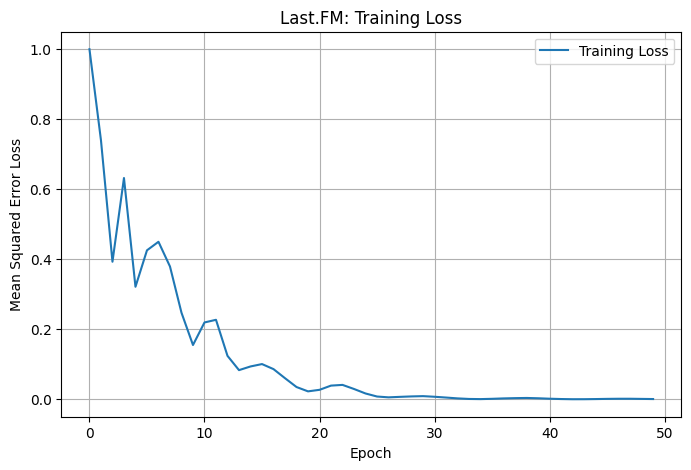

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss')
plt.title('Last.FM: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.grid(True)
plt.show()

### (3)

Knowledge Graph:

In [16]:
from src.model import KGCN
from src.dataset import DataLoader

In [17]:
args = {
    'dataset': 'music',
    'aggregator': 'sum',
    'n_epochs': 20,
    'neighbor_sample_size': 8,
    'dim': 16,
    'n_iter': 1,
    'batch_size': 32,
    'l2_weight': 1e-4,
    'lr': 5e-4,
    'ratio': 0.8
}

In [18]:
data_loader = DataLoader(args['dataset'])
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()

# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label

# train test split
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args['ratio'], shuffle=False, random_state=999)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args['batch_size'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size'])

# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['l2_weight'])
print('device: ', device)


# train
loss_list = []
test_loss_list = []
auc_score_list = []

for epoch in range(args['n_epochs']):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    
    # print train loss per every epoch
    print('[Epoch {}]train_loss: '.format(epoch+1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))
        
    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        print('[Epoch {}]test_loss: '.format(epoch+1), test_loss / len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))

Construct knowledge graph ... Done
Build dataset dataframe ... Done
device:  cpu
[Epoch 1]train_loss:  0.9918195483141963
[Epoch 1]test_loss:  0.8847978265780323
[Epoch 2]train_loss:  0.7906525194701212
[Epoch 2]test_loss:  0.7406884294635845
[Epoch 3]train_loss:  0.706745417304935
[Epoch 3]test_loss:  0.7034181432903938
[Epoch 4]train_loss:  0.6907650450133737
[Epoch 4]test_loss:  0.6964342526669772
[Epoch 5]train_loss:  0.6869152093744143
[Epoch 5]test_loss:  0.6941369994631353
[Epoch 6]train_loss:  0.6841894000402816
[Epoch 6]test_loss:  0.6926226001865459
[Epoch 7]train_loss:  0.6809226316703277
[Epoch 7]test_loss:  0.6908681388171214
[Epoch 8]train_loss:  0.6757107055108428
[Epoch 8]test_loss:  0.6873301845676494
[Epoch 9]train_loss:  0.6647349102413801
[Epoch 9]test_loss:  0.6772071944092805
[Epoch 10]train_loss:  0.63836747087095
[Epoch 10]test_loss:  0.6488221238244255
[Epoch 11]train_loss:  0.5851554798562083
[Epoch 11]test_loss:  0.5956841196653978
[Epoch 12]train_loss:  0.51

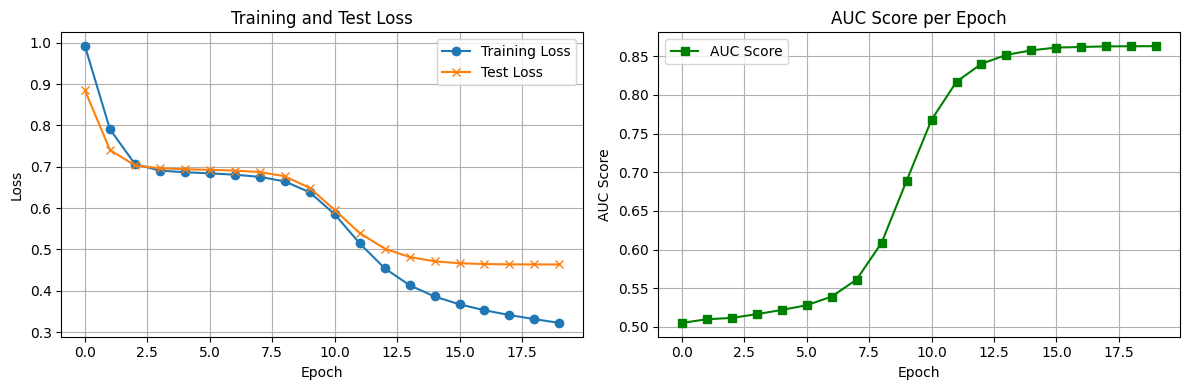

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 第一个子图：训练和测试损失
ax1.plot(loss_list, label='Training Loss', marker='o')
ax1.plot(test_loss_list, label='Test Loss', marker='x')
ax1.set_title('Training and Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# 第二个子图：AUC 分数
ax2.plot(auc_score_list, label='AUC Score', color='green', marker='s')
ax2.set_title('AUC Score per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC Score')
ax2.legend()
ax2.grid(True)

# 调整子图的布局
plt.tight_layout()
plt.show()